In [79]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
import numpy as np
import xml.etree.ElementTree as ET
import gzip
import random
import subprocess
import sys
import os
import networkx as nx
from pathlib import Path
import math
import json
import numpy as np

os.environ["LD_LIBRARY_PATH"] = os.path.expanduser("~/Libs/libnsl")
os.environ["SUMO_HOME" ] = os.path.expanduser("~/Envs/sumo-env/lib/python3.10/site-packages/sumo")

sys.path.append('/home/hoai-linh.dao/Works/EVCS/CEREMA-Mini/src')
from rawDataProcessing import autoFillMissingInfo, buildDetailedData

In [ ]:
MAPPING_JSON = "/home/hoai-linh.dao/Works/EVCS/CEREMA-Mini/data/processed-data/AMP-mapping.json"

DIR = Path("/home/hoai-linh.dao/Works/EVCS/CEREMA-Mini/data/processed-data/regional-traffic-flow/marseille")
NAME = DIR.name
RAW_CSV = DIR / f"raw-{NAME}.csv"
INTERPOLATED_CSV = DIR / f"interpolated-{NAME}.csv"
MAPPED_INTERPOLATED_CSV = DIR / f"mapped-interpolated-{NAME}.csv"
DETAILED_CSV = DIR / f"detailed-{NAME}.csv"
DATA_JSON = DIR / f"{NAME}-from-doc.json"
OD_MATRICES_DIR = DIR / "od_matrices" 
START_HOUR = 3

# MAIN

In [81]:
# df = pd.read_csv(RAW_CSV) 
# df.iloc[:, 1] = df.iloc[:, 1] *1.02

# df.to_csv(RAW_CSV, index=False)

In [82]:
df1 = pd.read_csv(RAW_CSV)
df1.columns = ["Heures", "Nombre de départs"]
df1["Nombre de départs"] = df1["Nombre de départs"].clip(lower=0)
df1.to_csv(RAW_CSV, index=False)

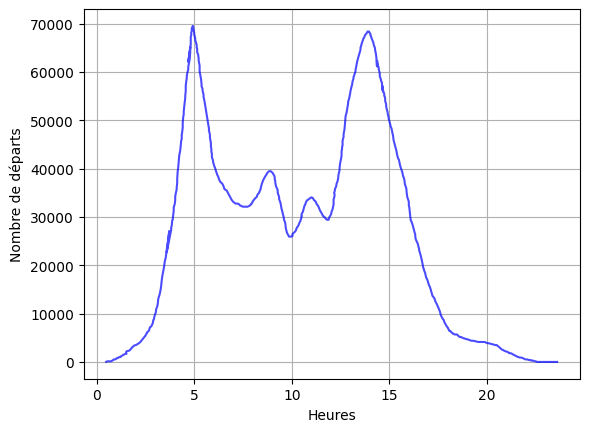

In [83]:
plt.plot(df1["Heures"], df1["Nombre de départs"], linestyle='-', color='b', alpha=0.7)
plt.xlabel("Heures")
plt.ylabel("Nombre de départs")
plt.grid(True)
plt.show()

In [84]:
df1 = df1.groupby('Heures', as_index=False).mean()

In [85]:
df2 = df1.sort_values(by='Heures')
li = interp1d(df2['Heures'], df2['Nombre de départs'], kind='linear', fill_value='extrapolate')

x_interp = np.linspace(0, 24, num=24*100+1)  
y_interp = li(x_interp)
y_interp = np.clip(y_interp, a_min=0, a_max=None)

results = []
for h in range(24):
    mask = (x_interp >= h) & (x_interp < h + 1)
    x_h = x_interp[mask]
    y_h = y_interp[mask]
    area = np.trapezoid(y_h, x_h)
    results.append({'Heures': h, 'Nombre de départs': area})

df3 = pd.DataFrame(results)
df3.to_csv(INTERPOLATED_CSV, index=False)
df3

,Heures,Nombre de départs
0,0,135.820156
1,1,1941.395148
2,2,5722.050255
3,3,20595.456340
4,4,52302.380830
5,5,54176.375895
6,6,36169.248742
7,7,32145.244099
8,8,36414.188480
9,9,31384.472228


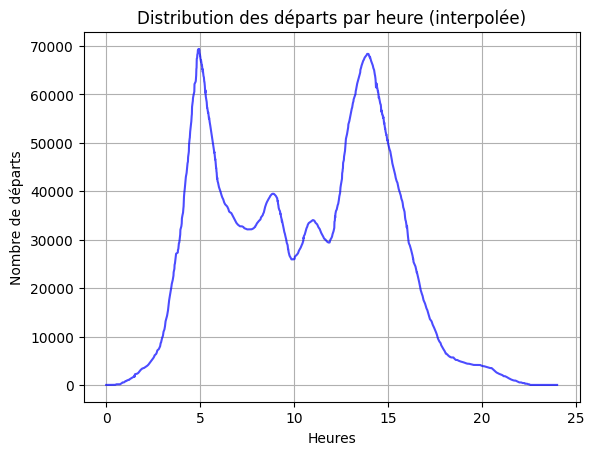

In [86]:
plt.plot(x_interp, y_interp, linestyle='-', color='b', alpha=0.7)

plt.xlabel("Heures")
plt.ylabel("Nombre de départs")
plt.title("Distribution des départs par heure (interpolée)")
plt.grid(True)

plt.show()

In [87]:
df4 = pd.read_csv(INTERPOLATED_CSV)

df4['Heures'] = df4['Heures'].astype(int)
df4['Heures'] = (df4['Heures'] + START_HOUR) % 24
df4['Nombre de départs'] = df4['Nombre de départs'].apply(math.ceil)

df4.to_csv(MAPPED_INTERPOLATED_CSV, index=False)

In [88]:
df5 = pd.read_csv(MAPPED_INTERPOLATED_CSV)
sum(df5['Nombre de départs'])

586679

In [89]:
autoFillMissingInfo(DATA_JSON)


/home/hoai-linh.dao/Works/EVCS/CEREMA-Mini/data/processed-data/regional-traffic-flow/ouest-etang-de-berre/ouest-etang-de-berre-from-doc.json is already complete for 'regional_trips'.
Updated '/home/hoai-linh.dao/Works/EVCS/CEREMA-Mini/data/processed-data/regional-traffic-flow/ouest-etang-de-berre/ouest-etang-de-berre-from-doc.json': added distribution_trips_ratio, incoming_flow_ratio, outgoing_flow_ratio.


In [90]:
buildDetailedData(DATA_JSON, MAPPED_INTERPOLATED_CSV, MAPPING_JSON, DETAILED_CSV, OD_MATRICES_DIR)


,heure,marseille_out,marseille_in,sud-est_out,sud-est_in,aix-en-provence_out,aix-en-provence_in,est-etang-de-berre_out,est-etang-de-berre_in,nord-ouest_out,nord-ouest_in,outside_out,outside_in,ouest-etang-de-berre,total
0,3,2,2,2,2,2,2,4,4,3,3,1,1,64,92
1,4,27,27,22,22,22,22,46,47,40,41,10,10,966,1302
2,5,78,79,63,64,63,64,135,137,118,119,29,29,2857,3835
3,6,279,282,227,230,227,230,486,491,424,428,103,104,10289,13800
4,7,708,716,576,582,576,582,1233,1247,1075,1087,260,263,26139,35044
5,8,733,741,596,603,596,603,1278,1292,1114,1126,269,273,27075,36299
6,9,490,495,398,403,398,403,853,863,744,752,180,182,18073,24234
7,10,435,440,354,358,354,358,758,767,661,668,160,162,16063,21538
8,11,493,499,401,406,401,406,859,869,749,757,181,183,18195,24399
9,12,425,430,346,350,346,350,740,749,645,653,156,158,15680,21028


In [91]:
df6 = pd.read_csv(DETAILED_CSV)
print(sum(df6[NAME]))
print(sum(df6['total']))


293124
393087
